In [1]:
import os
import multiprocessing
import datetime
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
PATH_TO_ADA = os.environ['PATH_TO_ADA']

# from ada.ui.uiManager import AirfoilGeometry
from ada.analysis.apis.xfoil import AnalysisCase
from ada.analysis.apis.xfoil.api_ui import generateXfoilResult
from ada.analysis.apis.xfoil.polarPlot import polarPlot

from ada.analysis.saveLoadAnalysisCase import saveAnalysisCase, loadAnalysisCase

import pandas as pd
from ada.geometry.airfoils.kulfan import Kulfan
from matplotlib.gridspec import GridSpec
# import matplotlib.pyplot as plt
plt.rcParams['text.usetex'] = True
plt.rcParams.update({'font.size': 15})
import matplotlib
colors = ['#0065cc', '#e69f00', '#009e73', '#d55e00', '#56b4ff', '#fca7c7', '#ede13f', '#666666', '#000000']
matplotlib.rcParams['axes.prop_cycle'] = matplotlib.cycler(color=colors)
from ada.analysis.apis.xfoil.helperFunctions import truncate_colormap, handleZeroDivide, get_colors, computeNormals, get_fractional_color

import natsort

from ada.geometry.airfoils.kulfan import units

def generateAirfoil(aflString, useFits=False):
    aflString = aflString.replace(' ','')
    aflString = aflString.lower()
    if aflString[0:4].lower() == 'naca':
        nacaNumbers = aflString[4:]
        if len(nacaNumbers)!=4:
            return 'Error: invalid naca4'
        else:
            afl1 = Kulfan() 
            afl1.naca4_like(int(nacaNumbers[0]), int(nacaNumbers[1]), int(nacaNumbers[2:]))
            # uiManager.geometryItems.append(afl1)

    else:
        # this needs to utilize the large database of airfoils
        afl1 = Kulfan()

        if useFits:
            airfoil_directories = [
                PATH_TO_ADA + 'ada/geometry/airfoil_scraping/raw_airfoil_files/uiuc_airfoils',
                PATH_TO_ADA + 'ada/geometry/airfoil_scraping/raw_airfoil_files/airfoiltools_airfoils',
                PATH_TO_ADA + 'ada/geometry/airfoil_files',
            ]
        else:
            airfoil_directories = [
                '/Users/cjkarch/root/research/windTurbines',
                PATH_TO_ADA + 'ada/geometry/airfoil_scraping/raw_airfoil_files/uiuc_airfoils',
                PATH_TO_ADA + 'ada/geometry/airfoil_scraping/raw_airfoil_files/airfoiltools_airfoils',
                PATH_TO_ADA + 'ada/geometry/airfoil_files',
            ]

        airfoil_directory_data = {}
        for afl_dir in airfoil_directories:
            # file_data_dict = {}
            pth = afl_dir
            combined = os.listdir(pth)
            files   = [f for f in combined if os.path.isfile(pth + os.sep + f) and '.dat' in f]
            for fl in files:
                if fl not in list(airfoil_directory_data.keys()):
                    airfoil_directory_data[fl] = pth + os.sep + fl

        search_file = aflString + '.dat'
        afl1.fit2file(airfoil_directory_data[search_file])

    return afl1

In [2]:
print('hi')

hi


In [4]:
combined = os.listdir('.')
files   = natsort.natsorted([f for f in combined if os.path.isfile(f)], alg=natsort.ns.IGNORECASE)
# folders = natsort.natsorted([f for f in combined if not os.path.isfile(f) and 'rundata' in f], alg=natsort.ns.IGNORECASE)
folders = natsort.natsorted([f for f in combined if not os.path.isfile(f) and 'keep_' in f], alg=natsort.ns.IGNORECASE)
activeFolder = folders[-1]

combined2 = os.listdir(activeFolder)
airfoil_folders = natsort.natsorted([f for f in combined2 if not os.path.isfile(f) and '.' not in f], alg=natsort.ns.IGNORECASE)

dataDict = {}
dataDict['name']        = []
dataDict['alpha']       = []
dataDict['cl']          = []
dataDict['cd']          = []
dataDict['cm']          = []
dataDict['xtp_u']       = []
dataDict['xtp_l']       = []
dataDict['xtr_u']       = []
dataDict['xtr_l']       = []
dataDict['re']          = []
dataDict['m']           = []
dataDict['n_crit']      = []
dataDict['n_panels']    = []
dataDict['file_number'] = []
dataDict['file_index']  = []


rcs = []

chk_afl = 's832'
# chk_afl = 's831'
# chk_afl = 's830'
# chk_afl = 's818'
# chk_afl = 'du_00-w2-350'
# chk_afl = 'du_00-w2-401'
# chk_afl = 'du_00-w-212'
# chk_afl = 'du_91-w2-250'
# chk_afl = 'du_93-w-210'
# chk_afl = 'du_95-w-180'
# chk_afl = 'du_96-w-180'
# chk_afl = 'du_97-w-300'
# chk_afl = 'riso-b-15'
# chk_afl = 'riso-b-17'
# chk_afl = 'riso-b-20'
# chk_afl = 'riso-b-23'
# chk_afl = 'riso-b-29'
# chk_afl = 'riso-b-35'
# chk_afl = 'ffa-w1-128'
# chk_afl = 'ffa-w1-152'
# chk_afl = 'ffa-w1-182'
# chk_afl = 'ffa-w1-211'
# chk_afl = 'ffa-w1-242'
# chk_afl = 'ffa-w1-271'
# chk_afl = 'ffa-w2-152'
# chk_afl = 'ffa-w2-210'
# chk_afl = 'ffa-w3-211'
# chk_afl = 'ffa-w3-241'
# chk_afl = 'ffa-w3-270'
# chk_afl = 'ffa-w3-301'
# chk_afl = 'ffa-w3-332'
# chk_afl = 'ffa-w3-360'

for i,aflName in enumerate(airfoil_folders):
    if aflName == chk_afl:
        print('Loading %d of %d : %s ...'%(i+1, len(airfoil_folders), aflName))
        combined3 = os.listdir(activeFolder+os.sep+aflName)
        data_files   = natsort.natsorted([f for f in combined3 if os.path.isfile(activeFolder+os.sep+aflName+os.sep+f) and 'data' in f and 'json' in f], alg=natsort.ns.IGNORECASE)

        n_cases = 0
        for ii,df in enumerate(data_files):
            rcs_load = loadAnalysisCase(activeFolder+os.sep+aflName+os.sep+df)
            n_cases += len(rcs_load)
            for rc in rcs_load:
                rcs.append(rc)

                dataDict['name'].append(aflName)
                if 'alpha' in list(rc.inputs.keys()):
                    dataDict['alpha'].append( rc.inputs['alpha'] )
                    dataDict['cl'].append( rc.outputs['cl'] )
                else:
                    dataDict['alpha'].append( rc.outputs['alpha'] )
                    dataDict['cl'].append( rc.inputs['cl'] )
                dataDict['cd'].append( rc.outputs['cd'] )
                dataDict['cm'].append( rc.outputs['cm'] )
                dataDict['xtp_u'].append( rc.inputs['xtr_u'] )
                dataDict['xtp_l'].append( rc.inputs['xtr_l'] )
                dataDict['xtr_u'].append( rc.outputs['xtr_u'] )
                dataDict['xtr_l'].append( rc.outputs['xtr_l'] )
                dataDict['re'].append( rc.inputs['re'] )
                dataDict['m'].append( rc.inputs['m'] )
                dataDict['n_crit'].append( rc.inputs['n_crit'] )
                dataDict['n_panels'].append( rc.inputs['n_panels'] )
                
        # df_afl = pd.DataFrame.from_dict(dataDict)
    
    
# print('Percent Complete : ', n_cases/186945 * 100)

df_master = pd.DataFrame.from_dict(dataDict)
print('Done!')

# print(df_master)

Loading 31 of 31 : s832 ...
Done!


In [4]:
combined = os.listdir('.')
files   = natsort.natsorted([f for f in combined if os.path.isfile(f)], alg=natsort.ns.IGNORECASE)
# folders = natsort.natsorted([f for f in combined if not os.path.isfile(f) and 'rundata' in f], alg=natsort.ns.IGNORECASE)
folders = natsort.natsorted([f for f in combined if not os.path.isfile(f) and 'keep_' in f], alg=natsort.ns.IGNORECASE)
activeFolder = folders[-1]

combined2 = os.listdir(activeFolder)
airfoil_folders = natsort.natsorted([f for f in combined2 if not os.path.isfile(f) and '.' not in f], alg=natsort.ns.IGNORECASE)

# dataDict = {}
# dataDict['name']        = []
# dataDict['alpha']       = []
# dataDict['cl']          = []
# dataDict['cd']          = []
# dataDict['cm']          = []
# dataDict['xtp_u']       = []
# dataDict['xtp_l']       = []
# dataDict['xtr_u']       = []
# dataDict['xtr_l']       = []
# dataDict['re']          = []
# dataDict['m']           = []
# dataDict['n_crit']      = []
# dataDict['n_panels']    = []
# dataDict['file_number'] = []
# dataDict['file_index']  = []


rcs = []

# chk_afl = 's832'
# chk_afl = 's831'
# chk_afl = 's830'
# chk_afl = 's818'
# chk_afl = 'du_00-w2-350'
# chk_afl = 'du_00-w2-401'
# chk_afl = 'du_00-w-212'
# chk_afl = 'du_91-w2-250'
# chk_afl = 'du_93-w-210'
# chk_afl = 'du_95-w-180'
# chk_afl = 'du_96-w-180'
# chk_afl = 'du_97-w-300'
# chk_afl = 'riso-b-15'
# chk_afl = 'riso-b-17'
# chk_afl = 'riso-b-20'
# chk_afl = 'riso-b-23'
# chk_afl = 'riso-b-29'
# chk_afl = 'riso-b-35'
# chk_afl = 'ffa-w1-128'
# chk_afl = 'ffa-w1-152'
# chk_afl = 'ffa-w1-182'
# chk_afl = 'ffa-w1-211'
# chk_afl = 'ffa-w1-242'
# chk_afl = 'ffa-w1-271'
# chk_afl = 'ffa-w2-152'
# chk_afl = 'ffa-w2-210'
# chk_afl = 'ffa-w3-211'
# chk_afl = 'ffa-w3-241'
# chk_afl = 'ffa-w3-270'
# chk_afl = 'ffa-w3-301'
# chk_afl = 'ffa-w3-332'
# chk_afl = 'ffa-w3-360'

airfoil_folders = ['s831','s832']
for i,aflName in enumerate(airfoil_folders):
    # if aflName == chk_afl:
    dataDict = {}
    dataDict['name']        = []
    dataDict['alpha']       = []
    dataDict['cl']          = []
    dataDict['cd']          = []
    dataDict['cm']          = []
    dataDict['xtp_u']       = []
    dataDict['xtp_l']       = []
    dataDict['xtr_u']       = []
    dataDict['xtr_l']       = []
    dataDict['re']          = []
    dataDict['m']           = []
    dataDict['n_crit']      = []
    dataDict['n_panels']    = []
    dataDict['file_number'] = []
    dataDict['file_index']  = []

    print('Loading %d of %d : %s ...'%(i+1, len(airfoil_folders), aflName))
    combined3 = os.listdir(activeFolder+os.sep+aflName)
    data_files   = natsort.natsorted([f for f in combined3 if os.path.isfile(activeFolder+os.sep+aflName+os.sep+f) and 'data' in f and 'json' in f], alg=natsort.ns.IGNORECASE)

    n_cases = 0
    for ii,df in enumerate(data_files):
        try:
            rcs_load = loadAnalysisCase(activeFolder+os.sep+aflName+os.sep+df)
        except:
            rcs_load = []
        n_cases += len(rcs_load)
        for iii,rc in enumerate(rcs_load):
            # rcs.append(rc)
            dataDict['name'].append(aflName)
            if 'alpha' in list(rc.inputs.keys()):
                dataDict['alpha'].append( rc.inputs['alpha'] )
                dataDict['cl'].append( rc.outputs['cl'] )
            else:
                dataDict['alpha'].append( rc.outputs['alpha'] )
                dataDict['cl'].append( rc.inputs['cl'] )
            dataDict['cd'].append( rc.outputs['cd'] )
            dataDict['cm'].append( rc.outputs['cm'] )
            dataDict['xtp_u'].append( rc.inputs['xtr_u'] )
            dataDict['xtp_l'].append( rc.inputs['xtr_l'] )
            dataDict['xtr_u'].append( rc.outputs['xtr_u'] )
            dataDict['xtr_l'].append( rc.outputs['xtr_l'] )
            dataDict['re'].append( rc.inputs['re'] )
            dataDict['m'].append( rc.inputs['m'] )
            dataDict['n_crit'].append( rc.inputs['n_crit'] )
            dataDict['n_panels'].append( rc.inputs['n_panels'] )
            dataDict['file_number'].append( ii )
            dataDict['file_index'].append( iii )

    df_afl = pd.DataFrame.from_dict(dataDict)
    df_afl.to_csv(activeFolder+os.sep+aflName+os.sep+aflName+'_polar_data.csv', index=False )

    
# print('Percent Complete : ', n_cases/186945 * 100)

# df_master = pd.DataFrame.from_dict(dataDict)
print('Done!')

# print(df_master)

Loading 1 of 2 : s831 ...
Loading 2 of 2 : s832 ...
Done!


In [19]:
df_test = pd.read_csv(activeFolder+os.sep+aflName+os.sep+'polar_data.csv')
# print('done')
print(df_test)
# print(len(df_test.columns))

        name  alpha        cl        cd        cm  xtp_u  xtp_l     xtr_u  \
0       s832  -30.0 -0.785064  0.331811  0.080310    0.4    0.5  0.400000   
1       s832  -29.0 -0.756932  0.320999  0.071480    0.5    0.0  0.500000   
2       s832  -29.0 -0.756932  0.320999  0.071480    0.5    0.0  0.500000   
3       s832  -28.0 -0.723099  0.310954  0.060089    0.2    0.0  0.200000   
4       s832  -28.0 -0.397599  0.256199  0.004949    0.3    0.0  0.300000   
...      ...    ...       ...       ...       ...    ...    ...       ...   
127023  s832   30.0  1.350503  0.372995 -0.230695    1.0    0.8  0.000297   
127024  s832   30.0  0.796776  0.337150 -0.123098    0.4    0.3  0.000287   
127025  s832   30.0  0.797080  0.337241 -0.123232    0.3    0.4  0.000287   
127026  s832   30.0  1.377843  0.320045 -0.208920    0.0    0.6  0.000000   
127027  s832   30.0  1.671073  0.229086 -0.143120    0.0    0.5  0.000000   

           xtr_l          re  m  n_crit  n_panels  file_number  file_index 

In [5]:
print(df_master)

        name  alpha        cl        cd        cm  xtp_u  xtp_l     xtr_u  \
0       s832  -30.0 -0.785064  0.331811  0.080310    0.4    0.5  0.400000   
1       s832  -29.0 -0.756932  0.320999  0.071480    0.5    0.0  0.500000   
2       s832  -29.0 -0.756932  0.320999  0.071480    0.5    0.0  0.500000   
3       s832  -28.0 -0.723099  0.310954  0.060089    0.2    0.0  0.200000   
4       s832  -28.0 -0.397599  0.256199  0.004949    0.3    0.0  0.300000   
...      ...    ...       ...       ...       ...    ...    ...       ...   
127023  s832   30.0  1.350503  0.372995 -0.230695    1.0    0.8  0.000297   
127024  s832   30.0  0.796776  0.337150 -0.123098    0.4    0.3  0.000287   
127025  s832   30.0  0.797080  0.337241 -0.123232    0.3    0.4  0.000287   
127026  s832   30.0  1.377843  0.320045 -0.208920    0.0    0.6  0.000000   
127027  s832   30.0  1.671073  0.229086 -0.143120    0.0    0.5  0.000000   

           xtr_l          re  m  n_crit  n_panels  
0       0.002471   1000

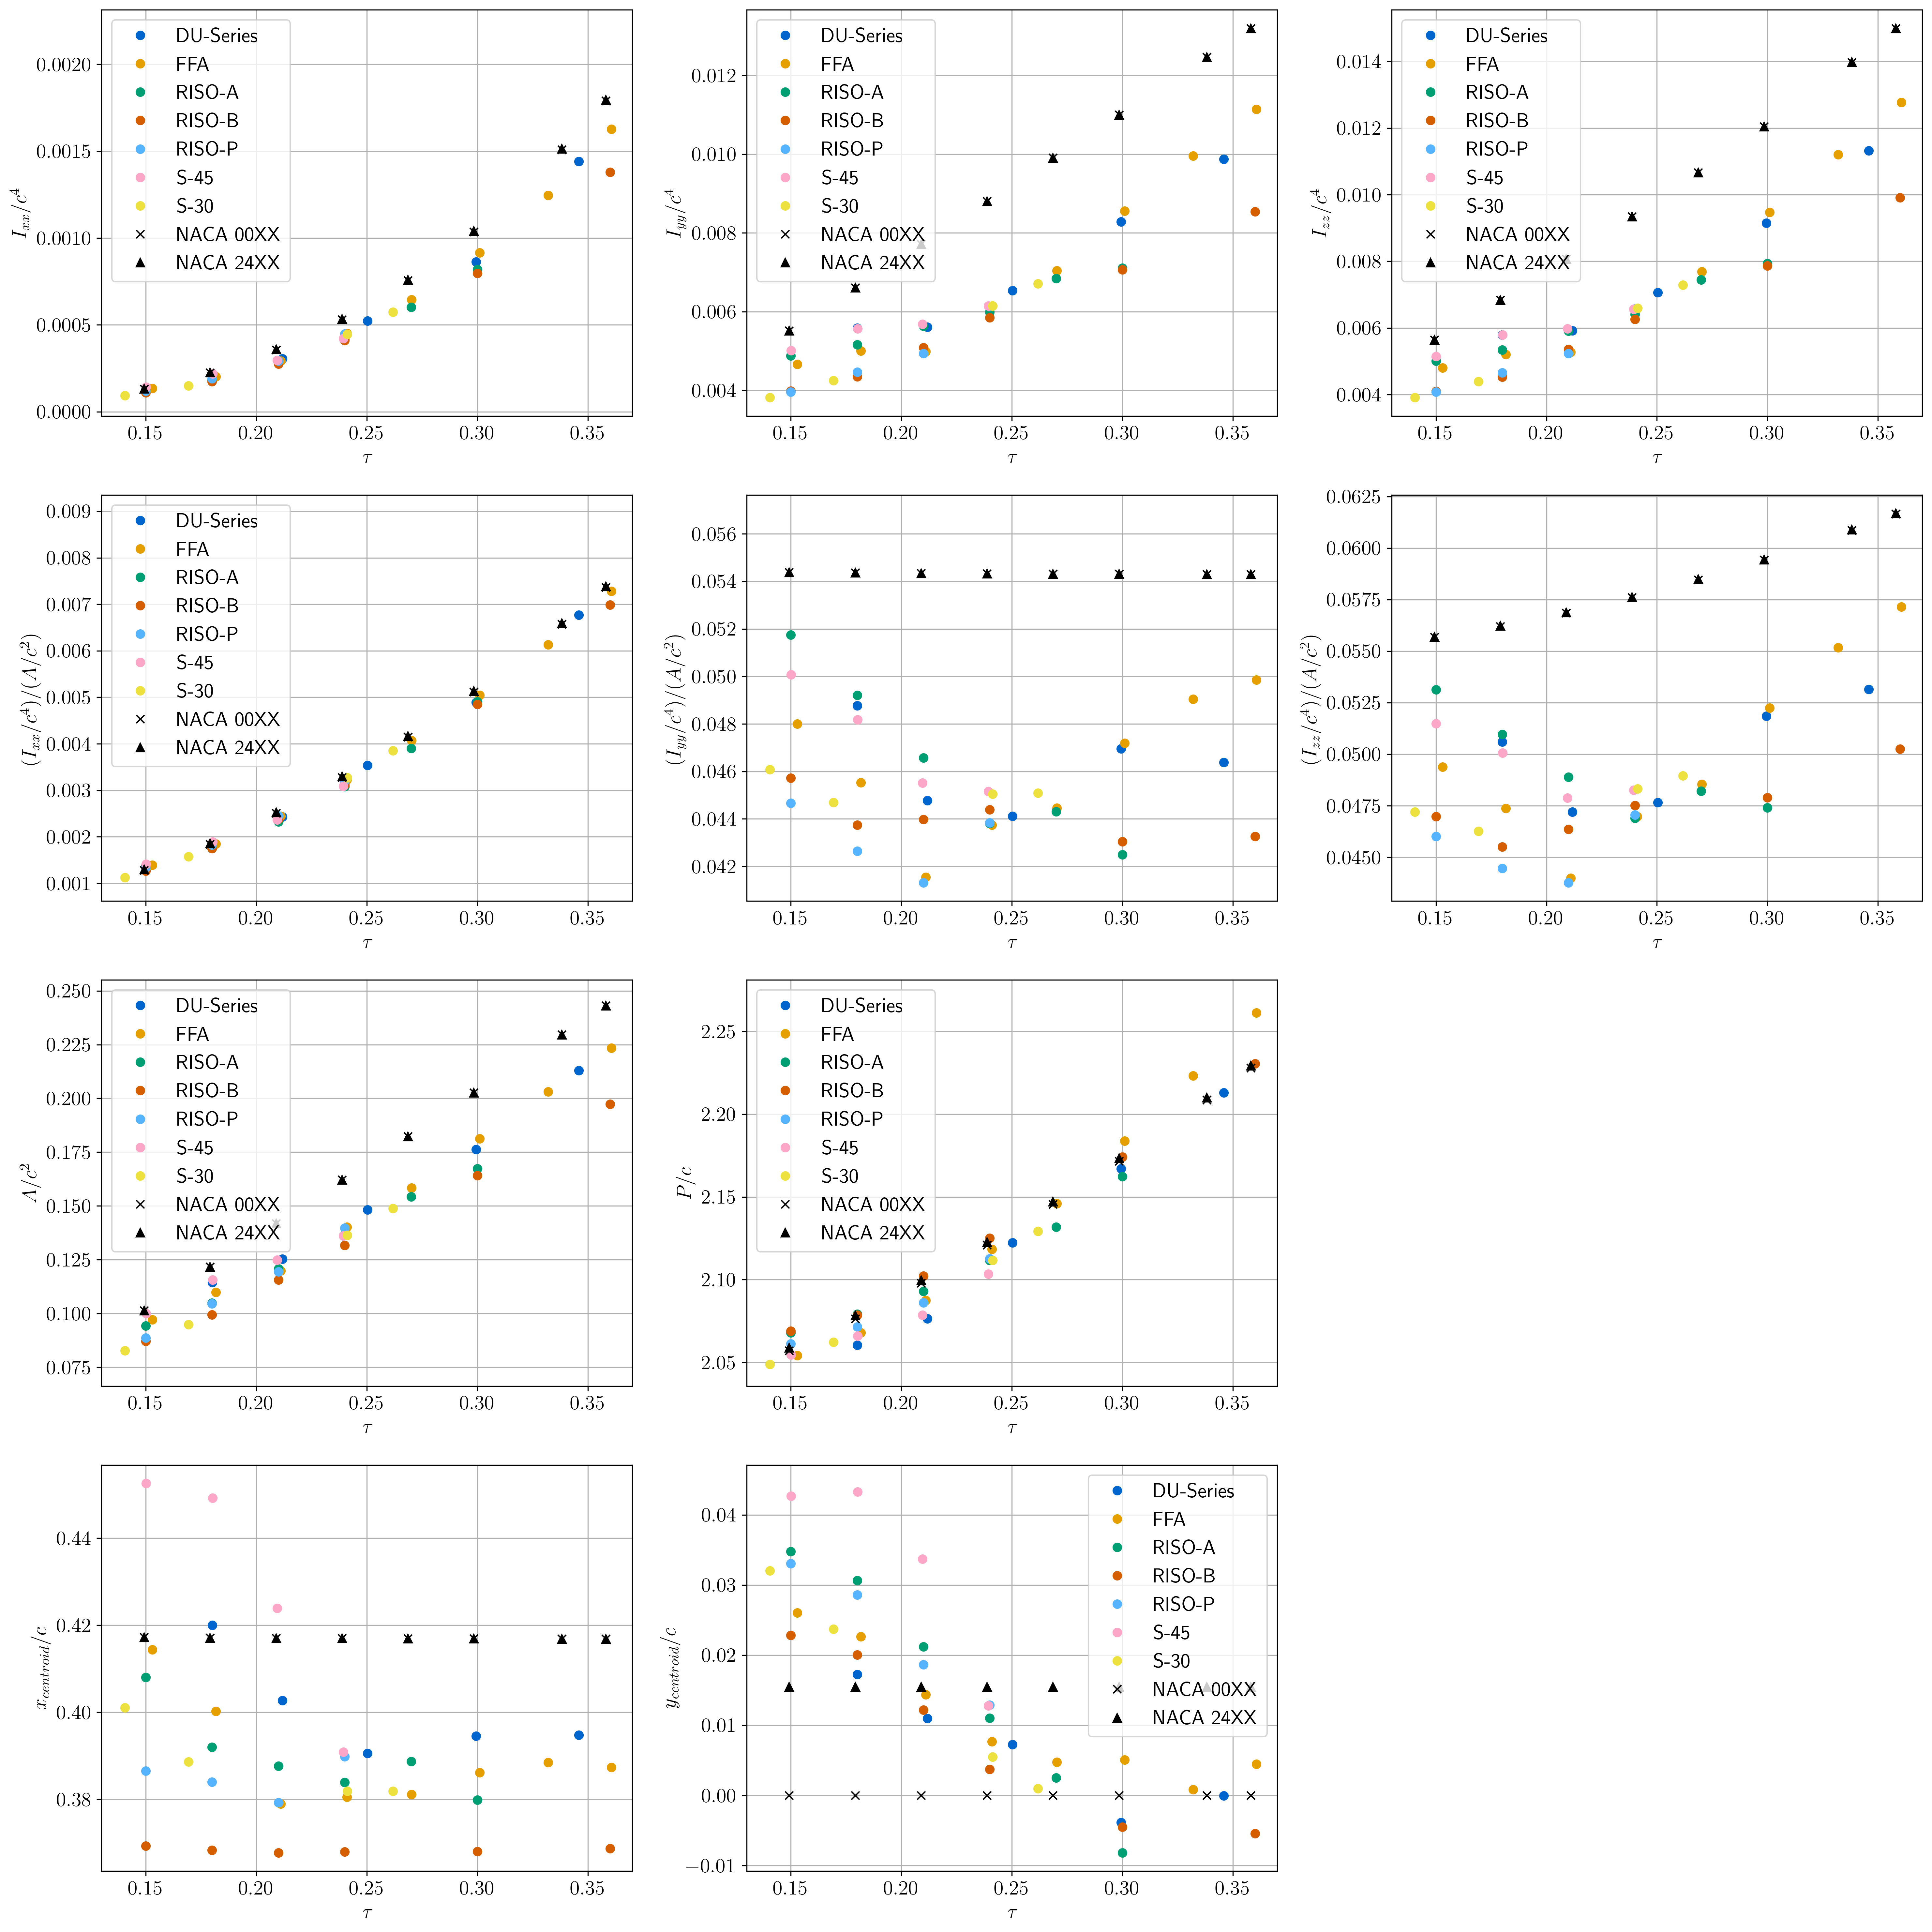

In [7]:
geometry_parameters = { 
 # 'du_91-w2-250': {'tau': 0.24999700829067095, 'Ixx': 0.0005228571311946058,  'Iyy': 0.006508841340056585,  'Izz': 0.00703169847125119,   'A': 0.14794687040351723, 'P': 2.1216670560289086, 'Cx': 0.3903467659879909,  'Cy': 0.006871133013360751   },
 # 'du_93-w-210':  {'tau': 0.21000543190412232, 'Ixx': 0.00029846140034772906, 'Iyy': 0.005691435672616003,  'Izz': 0.0059898970729637315, 'A': 0.125000184209337,   'P': 2.0783365317247795, 'Cx': 0.4055182991601442,  'Cy': 0.011013317798896426    },
 # 'du_96-w-180':  {'tau': 0.17999838780597668, 'Ixx': 0.00020916940697227385, 'Iyy': 0.00561305312735079,   'Izz': 0.005822222534323064,  'A': 0.11450310029534394, 'P': 2.0644934763370135, 'Cx': 0.41988595694461417, 'Cy': 0.018973606651964587    },
 # 'du_97-w-300':  {'tau': 0.29997856927920125, 'Ixx': 0.0008671468897017599,  'Iyy': 0.008292327568991458,  'Izz': 0.009159474458693218,  'A': 0.17666596513220403, 'P': 2.166777878747115,  'Cx': 0.3944840348340286,  'Cy': -0.00464613756486683    },
 #
 # 'du_96-w-180':  {'tau': 0.17994320665959534, 'Ixx': 0.0002089944313606312,  'Iyy': 0.005567944312962878,  'Izz': 0.005776938744323509,  'A': 0.11434051786008119, 'P': 2.0612158004504555, 'Cx': 0.41950518000951537, 'Cy': 0.01987021264625501     },
 'du_95-w-180':  {'tau': 0.18003262866447634, 'Ixx': 0.00020947136545671976, 'Iyy': 0.0055838073244073505, 'Izz': 0.00579327868986407,   'A': 0.11450493182225602, 'P': 2.06052473631044,   'Cx': 0.419999932823493,   'Cy': 0.01723346562231672     },
 # 'du_93-w-210':  {'tau': 0.21015782353257467, 'Ixx': 0.00031720648001843727, 'Iyy': 0.005874388417074011,  'Izz': 0.006191594897092448,  'A': 0.1276269314605557,  'P': 2.090689225947187,  'Cx': 0.40051598806790717, 'Cy': 0.019338385039812975    },
 'du_00-w-212':  {'tau': 0.21177864093871052, 'Ixx': 0.00030441464365183173, 'Iyy': 0.005609381630147995,  'Izz': 0.005913796273799826,  'A': 0.1252944079908068,  'P': 2.0764375857218376, 'Cx': 0.4027183169471095,  'Cy': 0.010984589416322776    },
 'du_91-w2-250': {'tau': 0.25033551542114685, 'Ixx': 0.0005238566734479776,  'Iyy': 0.006537647371596772,  'Izz': 0.00706150404504475,   'A': 0.1481757130080012,  'P': 2.1223785159677777, 'Cx': 0.3905901999279018,  'Cy': 0.007244556444934642    },
 'du_97-w-300':  {'tau': 0.2994246503613075,  'Ixx': 0.00086235872548436,    'Iyy': 0.008280702047165455,  'Izz': 0.009143060772649815,  'A': 0.1763318186132034,  'P': 2.1669865923529636, 'Cx': 0.3945529718653691,  'Cy': -0.0038864742515931647  },
 'du_00-w2-350': {'tau': 0.34583104785749375, 'Ixx': 0.0014419096008314676,  'Iyy': 0.009874445255768822,  'Izz': 0.01131635485660029,   'A': 0.21293103798872481, 'P': 2.21286661055835,   'Cx': 0.39480236230345206, 'Cy': -4.1471341749159885e-05 },
 'du_00-w2-401': {'tau': 0.3957844787543928,  'Ixx': 0.0022076647443998163,  'Iyy': 0.011581225892426106,  'Izz': 0.013788890636825922,  'A': 0.24650103016579686, 'P': 2.269954001570844,  'Cx': 0.39170767672115836, 'Cy': 0.0014934408855503151   },
 'ffa-w1-128':   {'tau': 0.12750849814843554, 'Ixx': 8.132709693253114e-05,  'Iyy': 0.0038350936423884982, 'Izz': 0.003916420739321029,  'A': 0.08013016598707215, 'P': 2.046811930909322,  'Cx': 0.40299800962882815, 'Cy': 0.03059455107255899     },
 # 'ffa-w1-152':   {'tau': 0.1525483709947077,  'Ixx': 0.00013598406726858062, 'Iyy': 0.004634336787590107,  'Izz': 0.004770320854858688,  'A': 0.09646915893274777, 'P': 2.0589900513465333, 'Cx': 0.40856945267787187, 'Cy': 0.031922415442732784    },
 'ffa-w1-182':   {'tau': 0.18165177758042678, 'Ixx': 0.00020287545637414744, 'Iyy': 0.005004175565515711,  'Izz': 0.005207051021889859,  'A': 0.10990506107797178, 'P': 2.0680484500692478, 'Cx': 0.4002466017385874,  'Cy': 0.022656252476535733    },
 # 'ffa-w1-211':   {'tau': 0.21090794904854615, 'Ixx': 0.0002912946042394546,  'Iyy': 0.005220783185790409,  'Izz': 0.005512077790029863,  'A': 0.12082562026346984, 'P': 2.0861674127966268, 'Cx': 0.38297105271029397, 'Cy': 0.015152646743960628    },
 # 'ffa-w1-242':   {'tau': 0.24156318254484285, 'Ixx': 0.0004479856546058336,  'Iyy': 0.006059389131132499,  'Izz': 0.006507374785738333,  'A': 0.13937944782145398, 'P': 2.1140543729137695, 'Cx': 0.3825501202499617,  'Cy': 0.0035319139467885844   },
 # 'ffa-w1-271':   {'tau': 0.2710067521195194,  'Ixx': 0.0006447983071823269,  'Iyy': 0.007306635810282676,  'Izz': 0.007951434117465003,  'A': 0.15922875298773506, 'P': 2.1477899223965076, 'Cx': 0.3864740789709034,  'Cy': 0.0001533956539705563   },
 'ffa-w2-152':   {'tau': 0.15295654612093265, 'Ixx': 0.000135174756376612,   'Iyy': 0.004664050379725665,  'Izz': 0.004799225136102278,  'A': 0.09717687009185645, 'P': 2.054175286992266,  'Cx': 0.4144011766088211,  'Cy': 0.02605417317621567     },
 # 'ffa-w2-210':   {'tau': 0.21026585153872637, 'Ixx': 0.0003009700088100929,  'Iyy': 0.005484788009815787,  'Izz': 0.00578575801862588,   'A': 0.12419465036566844, 'P': 2.0826324815927326, 'Cx': 0.3930429053792036,  'Cy': 0.008365982686258768    },
 'ffa-w3-211':   {'tau': 0.21099815017879747, 'Ixx': 0.0002927201511658959,  'Iyy': 0.004983746818345554,  'Izz': 0.00527646696951145,   'A': 0.119941030652691,   'P': 2.0874327005150684, 'Cx': 0.37894508413121175, 'Cy': 0.014382749242053764    },
 'ffa-w3-241':   {'tau': 0.24102874295292376, 'Ixx': 0.0004525405940502094,  'Iyy': 0.0061346138457503,    'Izz': 0.00658715443980051,   'A': 0.14022313510876605, 'P': 2.118476309202532,  'Cx': 0.3805660952062427,  'Cy': 0.007659037118049264    },
 'ffa-w3-270':   {'tau': 0.27025164104047084, 'Ixx': 0.0006450618362935872,  'Iyy': 0.007040878412906751,  'Izz': 0.007685940249200338,  'A': 0.15836097787311312, 'P': 2.14591817192102,   'Cx': 0.381098127234894,   'Cy': 0.004736368256215495    },
 'ffa-w3-301':   {'tau': 0.3009864714374209,  'Ixx': 0.0009151757841802956,  'Iyy': 0.008555564358393854,  'Izz': 0.00947074014257415,   'A': 0.18130619532247638, 'P': 2.183803719526516,  'Cx': 0.3861504877658255,  'Cy': 0.0050591377066402324   },
 'ffa-w3-332':   {'tau': 0.3319476680212506,  'Ixx': 0.0012456481333606487,  'Iyy': 0.009958627770812044,  'Izz': 0.011204275904172693,  'A': 0.20308715829234317, 'P': 2.2231220270732197, 'Cx': 0.38850031495079673, 'Cy': 0.0008504039871705853   },
 'ffa-w3-360':   {'tau': 0.36062253973276015, 'Ixx': 0.001627023029607418,   'Iyy': 0.011138406914472404,  'Izz': 0.012765429944079823,  'A': 0.2233982493582677,  'P': 2.2611481071442654, 'Cx': 0.38733249977468864, 'Cy': 0.004436630764629824    },
 'riso-a-12':    {'tau': 0.12000236243423955, 'Ixx': 8.486700346935257e-05,  'Iyy': 0.004255999893380951,  'Izz': 0.004340866896850303,  'A': 0.07484634068604132, 'P': 2.06958105771107,   'Cx': 0.40288365761263606, 'Cy': 0.04449040686581781     },
 'riso-a-15':    {'tau': 0.15000830883629224, 'Ixx': 0.0001297285183417979,  'Iyy': 0.004882042136880693,  'Izz': 0.005011770655222491,  'A': 0.09433574241516281, 'P': 2.0679722852454887, 'Cx': 0.4079926970780744,  'Cy': 0.034797275272843604    },
 'riso-a-18':    {'tau': 0.18000014007313675, 'Ixx': 0.00018374459997318296, 'Iyy': 0.005158102498214187,  'Izz': 0.00534184709818737,   'A': 0.10482791324302933, 'P': 2.0792224299613595, 'Cx': 0.3920251238955186,  'Cy': 0.03064664912562339     },
 'riso-a-21':    {'tau': 0.21000039870751203, 'Ixx': 0.00028110604792135107, 'Iyy': 0.0056287750191572,    'Izz': 0.0059098810670785516, 'A': 0.120865877120856,   'P': 2.0929988295186472, 'Cx': 0.3876387781928286,  'Cy': 0.02118908117871626     },
 'riso-a-24':    {'tau': 0.24000053844924488, 'Ixx': 0.0004211362798172955,  'Iyy': 0.0059889559494595125, 'Izz': 0.006410092229276808,  'A': 0.1366735065362398,  'P': 2.1117582182409005, 'Cx': 0.38391520170935034, 'Cy': 0.011034641736880013    },
 'riso-a-27':    {'tau': 0.27000112923702857, 'Ixx': 0.0006023080695709607,  'Iyy': 0.006838803918493338,  'Izz': 0.007441111988064299,  'A': 0.15435047181900258, 'P': 2.1317479711449328, 'Cx': 0.3887188620708913,  'Cy': 0.002526534573552587    },
 'riso-a-30':    {'tau': 0.3000061986512407,  'Ixx': 0.0008201266510798496,  'Iyy': 0.007109278298915804,  'Izz': 0.007929404949995653,  'A': 0.16728795284238684, 'P': 2.162298597159385,  'Cx': 0.3798721260314487,  'Cy': -0.008182362532262866   },
 'riso-b-15':    {'tau': 0.150007376275903,   'Ixx': 0.00011001431067582593, 'Iyy': 0.003983083491466248,  'Izz': 0.004093097802142074,  'A': 0.08712403774990624, 'P': 2.0689945642663417, 'Cx': 0.36926509211786557, 'Cy': 0.022845994712734345    },
 'riso-b-17':    {'tau': 0.1799980643900253,  'Ixx': 0.0001743622553027269,  'Iyy': 0.004350452800282467,  'Izz': 0.004524815055585194,  'A': 0.09944979368081013, 'P': 2.078681939535941,  'Cx': 0.3683051116219579,  'Cy': 0.020035528930980363    },
 'riso-b-20':    {'tau': 0.20999702372814077, 'Ixx': 0.0002751927851428137,  'Iyy': 0.005083748622921184,  'Izz': 0.005358941408063998,  'A': 0.11558786037012647, 'P': 2.102311154372228,  'Cx': 0.3677318117079296,  'Cy': 0.01217434664048821     },
 'riso-b-23':    {'tau': 0.2399927698518282,  'Ixx': 0.00041090407235838596, 'Iyy': 0.005847989311414991,  'Izz': 0.0062588933837733765, 'A': 0.1317409401361707,  'P': 2.125106389939396,  'Cx': 0.367957096815686,   'Cy': 0.003715473384104667    },
 'riso-b-29':    {'tau': 0.29999955492240477, 'Ixx': 0.0007964003096405682,  'Iyy': 0.007066507914991797,  'Izz': 0.007862908224632365,  'A': 0.16415959778500386, 'P': 2.1741178752684043, 'Cx': 0.36803973799616524, 'Cy': -0.0045183685496786655  },
 'riso-b-35':    {'tau': 0.35999831953711947, 'Ixx': 0.0013782033687260802,  'Iyy': 0.008536876921826241,  'Izz': 0.009915080290552322,  'A': 0.197295448491119,   'P': 2.230395392602811,  'Cx': 0.368657569813046,   'Cy': -0.005446257780942511   },
 'riso-p-15':    {'tau': 0.15000270636894356, 'Ixx': 0.00011948320067689854, 'Iyy': 0.003963367965261977,  'Izz': 0.004082851165938876,  'A': 0.08874189035301094, 'P': 2.061188161708214,  'Cx': 0.3865159252274691,  'Cy': 0.03305494907168323     },
 'riso-p-18':    {'tau': 0.18000210577231426, 'Ixx': 0.00019090224982628142, 'Iyy': 0.00446144873696888,   'Izz': 0.004652350986795162,  'A': 0.10462075289754864, 'P': 2.0714729576698403, 'Cx': 0.3840058712124099,  'Cy': 0.028590151837513556    },
 'riso-p-20':    {'tau': 0.20999771379295953, 'Ixx': 0.00029261942532376176, 'Iyy': 0.004937796378242421,  'Izz': 0.005230415803566183,  'A': 0.11950314131106105, 'P': 2.0859873684598567, 'Cx': 0.3792437960645646,  'Cy': 0.018658198493903627    },
 'riso-p-23':    {'tau': 0.23999148664964282, 'Ixx': 0.0004477541122174711,  'Iyy': 0.0061295371958905035, 'Izz': 0.006577291308107975,  'A': 0.13979335852576588, 'P': 2.1127594449954334, 'Cx': 0.3898411140762687,  'Cy': 0.012870769333456274    },
 's832':         {'tau': 0.15006953567602918, 'Ixx': 0.0001411977360682891,  'Iyy': 0.005008199164564799,  'Izz': 0.005149396900633088,  'A': 0.10002943388746915, 'P': 2.054622454612982,  'Cx': 0.4525939470532004,  'Cy': 0.04269292658742565     },
 's831':         {'tau': 0.18021396481495328, 'Ixx': 0.00021827314619045344, 'Iyy': 0.005570300448474674,  'Izz': 0.005788573594665128,  'A': 0.11562480750563076, 'P': 2.0660608979362927, 'Cx': 0.4492706015142796,  'Cy': 0.043265928092755916    },
 's830':         {'tau': 0.20951120151777008, 'Ixx': 0.0002955705854499721,  'Iyy': 0.005683471137383536,  'Izz': 0.0059790417228335075, 'A': 0.1248750294029981,  'P': 2.078634028787246,  'Cx': 0.4238952994206805,  'Cy': 0.03372259587713579     },
 's818':         {'tau': 0.23940076083444106, 'Ixx': 0.00042077835595807596, 'Iyy': 0.006147875618829381,  'Izz': 0.006568653974787456,  'A': 0.1361374884189227,  'P': 2.103468918107856,  'Cx': 0.39083772794889626, 'Cy': 0.01279026275796587     },
 's826':         {'tau': 0.1404969282595932,  'Ixx': 9.294627230688772e-05,  'Iyy': 0.003815961559870237,  'Izz': 0.003908907832177125,  'A': 0.0828092367380793,  'P': 2.0488263002331806, 'Cx': 0.4010565958215655,  'Cy': 0.032021652390770164    },
 's825':         {'tau': 0.16925441457508,    'Ixx': 0.00014938712155284799, 'Iyy': 0.004245220060132803,  'Izz': 0.004394607181685651,  'A': 0.09497577719262405, 'P': 2.0622061692547655, 'Cx': 0.38859907235840985, 'Cy': 0.023694778413222317    },
 's814':         {'tau': 0.24122669392386492, 'Ixx': 0.00044625535701698455, 'Iyy': 0.006147547510890594,  'Izz': 0.0065938028679075784, 'A': 0.1364765575534128,  'P': 2.1117772777471986, 'Cx': 0.38185745652279796, 'Cy': 0.005464761183848908    },
 's815':         {'tau': 0.2617901519147423,  'Ixx': 0.0005739346119423916,  'Iyy': 0.006712433030566674,  'Izz': 0.007286367642509065,  'A': 0.14885529516731208, 'P': 2.129192518028223,  'Cx': 0.3819059198594036,  'Cy': 0.000985574972722173    },

# Reference below
 'naca0015':     {'tau': 0.1492915644423714,  'Ixx': 0.00012984371336179377, 'Iyy': 0.0055162619663278985, 'Izz': 0.005646105679689692,  'A': 0.10142413117481822, 'P': 2.0570484987157136, 'Cx': 0.417215586543584,   'Cy': 1.1285749036011597e-13  },
 'naca0018':     {'tau': 0.1791200248143671,  'Ixx': 0.00022420262454742054, 'Iyy': 0.0066136240110617394, 'Izz': 0.00683782663560916,   'A': 0.12165895740956767, 'P': 2.076498058080606,  'Cx': 0.41711306590490493, 'Cy': 1.672948734124751e-14   },
 'naca0021':     {'tau': 0.20894848521065107, 'Ixx': 0.00035583582369038677, 'Iyy': 0.007710984228167065,  'Izz': 0.008066820051857451,  'A': 0.14189378364550956, 'P': 2.09784434761151,   'Cx': 0.4170397852734795,  'Cy': 7.201858859556408e-14   },
 'naca0024':     {'tau': 0.23877694557133475, 'Ixx': 0.0005309479814833609,  'Iyy': 0.008808343300835594,  'Izz': 0.009339291282318954,  'A': 0.1621286098793309,  'P': 2.1209106137415046, 'Cx': 0.416984796541273,   'Cy': -9.742993331698916e-14  },
 'naca0027':     {'tau': 0.26860540598759736, 'Ixx': 0.0007557437686113008,  'Iyy': 0.009905701612831443,  'Izz': 0.010661445381442744,  'A': 0.18236343611913616, 'P': 2.1455533067334027, 'Cx': 0.4169420107965088,  'Cy': 2.5101042794922347e-13  },
 'naca0030':     {'tau': 0.2984338663238293,  'Ixx': 0.0010364278557698488,  'Iyy': 0.01100305938743394,   'Izz': 0.012039487243203788,  'A': 0.20259826235017708, 'P': 2.1716527961007133, 'Cx': 0.4169077716151461,  'Cy': 2.8999386880408756e-13  },
 'naca0034':     {'tau': 0.33820514684860425, 'Ixx': 0.0015083347830918128,  'Iyy': 0.012466202502418615,  'Izz': 0.013974537285510426,  'A': 0.22957803066506385, 'P': 2.2085442562883832, 'Cx': 0.41687150814744345, 'Cy': 1.9064036480761413e-13  },
 'naca0036':     {'tau': 0.3580907870906,     'Ixx': 0.0017902796129384752,  'Iyy': 0.013197773870722561,  'Izz': 0.014988053483661036,  'A': 0.24306791482162948, 'P': 2.2278284316728714, 'Cx': 0.41685639525794516, 'Cy': -1.5062712341343554e-13 },
 'naca2415':     {'tau': 0.14929156450321826, 'Ixx': 0.0001321260681179256,  'Iyy': 0.0055162619685450555, 'Izz': 0.0056483880366629815, 'A': 0.10142413118156704, 'P': 2.0589841374060676, 'Cx': 0.41721558658157304, 'Cy': 0.015464224574999911    },
 'naca2418':     {'tau': 0.17912002482735817, 'Ixx': 0.00022693921927289566, 'Iyy': 0.0066136240110353465, 'Izz': 0.006840563230308242,  'A': 0.12165895740941911, 'P': 2.0783704427169027, 'Cx': 0.4171130659044172,  'Cy': 0.015465373708220915    },
 'naca2421':     {'tau': 0.20894848522011056, 'Ixx': 0.0003590266581566394,  'Iyy': 0.007710984228559482,  'Izz': 0.008070010886716121,  'A': 0.14189378364652333, 'P': 2.0996538016869915, 'Cx': 0.41703978527864755, 'Cy': 0.015466195095055252    },
 'naca2424':     {'tau': 0.23877694554217527, 'Ixx': 0.0005345930555438606,  'Iyy': 0.008808343299915714,  'Izz': 0.009342936355459575,  'A': 0.16212860987594382, 'P': 2.1226579396076897, 'Cx': 0.41698479653091475, 'Cy': 0.015466811452540663    },
 'naca2427':     {'tau': 0.2686054059167647,  'Ixx': 0.0007598430821759068,  'Iyy': 0.009905701610280239,  'Izz': 0.010665544692456145,  'A': 0.18236343611139477, 'P': 2.1472396184985243, 'Cx': 0.41694201077239285, 'Cy': 0.015467291028812818    },
 'naca2430':     {'tau': 0.2984338663561087,  'Ixx': 0.0010409814087754012,  'Iyy': 0.01100305938799694,   'Izz': 0.01204404079677234,   'A': 0.20259826235158565, 'P': 2.1732794112251828, 'Cx': 0.4169077716194367,  'Cy': 0.01546767480771128     },
 'naca2434':     {'tau': 0.33820514684967246, 'Ixx': 0.0015134939885994333,  'Iyy': 0.012466202502575253,  'Izz': 0.013979696491174686,  'A': 0.22957803066539492, 'P': 2.210093549997388,  'Cx': 0.4168715081488536,  'Cy': 0.015468081277218411    },
 'naca2436':     {'tau': 0.35809078713480935, 'Ixx': 0.00179574164469573,    'Iyy': 0.01319777387200868,   'Izz': 0.01499351551670441,   'A': 0.24306791482611864, 'P': 2.2293400970026767, 'Cx': 0.4168563952674143,  'Cy': 0.015468250673517994    },
}

style_lookup = { 
    'du_96-w-180':  {'color' : colors[0] , 'ms' : 'o' } ,
    'du_95-w-180':  {'color' : colors[0] , 'ms' : 'o' } ,
    'du_93-w-210':  {'color' : colors[0] , 'ms' : 'o' } ,
    'du_00-w-212':  {'color' : colors[0] , 'ms' : 'o' } ,
    'du_91-w2-250': {'color' : colors[0] , 'ms' : 'o' } ,
    'du_97-w-300':  {'color' : colors[0] , 'ms' : 'o' } ,
    'du_00-w2-350': {'color' : colors[0] , 'ms' : 'o' } ,
    'du_00-w2-401': {'color' : colors[0] , 'ms' : 'o' } ,
    'ffa-w1-128':   {'color' : colors[1] , 'ms' : 'o' } ,
    'ffa-w1-152':   {'color' : colors[1] , 'ms' : 'o' } ,
    'ffa-w1-182':   {'color' : colors[1] , 'ms' : 'o' } ,
    'ffa-w1-211':   {'color' : colors[1] , 'ms' : 'o' } ,
    'ffa-w1-242':   {'color' : colors[1] , 'ms' : 'o' } ,
    'ffa-w1-271':   {'color' : colors[1] , 'ms' : 'o' } ,
    'ffa-w2-152':   {'color' : colors[1] , 'ms' : 'o' } ,
    'ffa-w2-210':   {'color' : colors[1] , 'ms' : 'o' } ,
    'ffa-w3-211':   {'color' : colors[1] , 'ms' : 'o' } ,
    'ffa-w3-241':   {'color' : colors[1] , 'ms' : 'o' } ,
    'ffa-w3-270':   {'color' : colors[1] , 'ms' : 'o' } ,
    'ffa-w3-301':   {'color' : colors[1] , 'ms' : 'o' } ,
    'ffa-w3-332':   {'color' : colors[1] , 'ms' : 'o' } ,
    'ffa-w3-360':   {'color' : colors[1] , 'ms' : 'o' } ,
    'riso-a-12':    {'color' : colors[2] , 'ms' : 'o' } ,
    'riso-a-15':    {'color' : colors[2] , 'ms' : 'o' } ,
    'riso-a-18':    {'color' : colors[2] , 'ms' : 'o' } ,
    'riso-a-21':    {'color' : colors[2] , 'ms' : 'o' } ,
    'riso-a-24':    {'color' : colors[2] , 'ms' : 'o' } ,
    'riso-a-27':    {'color' : colors[2] , 'ms' : 'o' } ,
    'riso-a-30':    {'color' : colors[2] , 'ms' : 'o' } ,
    'riso-b-15':    {'color' : colors[3] , 'ms' : 'o' } ,
    'riso-b-17':    {'color' : colors[3] , 'ms' : 'o' } ,
    'riso-b-20':    {'color' : colors[3] , 'ms' : 'o' } ,
    'riso-b-23':    {'color' : colors[3] , 'ms' : 'o' } ,
    'riso-b-29':    {'color' : colors[3] , 'ms' : 'o' } ,
    'riso-b-35':    {'color' : colors[3] , 'ms' : 'o' } ,
    'riso-p-15':    {'color' : colors[4] , 'ms' : 'o' } ,
    'riso-p-18':    {'color' : colors[4] , 'ms' : 'o' } ,
    'riso-p-20':    {'color' : colors[4] , 'ms' : 'o' } ,
    'riso-p-23':    {'color' : colors[4] , 'ms' : 'o' } ,
    's832':         {'color' : colors[5] , 'ms' : 'o' } ,
    's831':         {'color' : colors[5] , 'ms' : 'o' } ,
    's830':         {'color' : colors[5] , 'ms' : 'o' } ,
    's818':         {'color' : colors[5] , 'ms' : 'o' } ,
    's826':         {'color' : colors[6] , 'ms' : 'o' } ,
    's825':         {'color' : colors[6] , 'ms' : 'o' } ,
    's814':         {'color' : colors[6] , 'ms' : 'o' } ,
    's815':         {'color' : colors[6] , 'ms' : 'o' } ,
#
    'naca0015':     {'color' : 'k'       , 'ms' : 'x'},
    'naca0018':     {'color' : 'k'       , 'ms' : 'x'},
    'naca0021':     {'color' : 'k'       , 'ms' : 'x'},
    'naca0024':     {'color' : 'k'       , 'ms' : 'x'},
    'naca0027':     {'color' : 'k'       , 'ms' : 'x'},
    'naca0030':     {'color' : 'k'       , 'ms' : 'x'},
    'naca0034':     {'color' : 'k'       , 'ms' : 'x'},
    'naca0036':     {'color' : 'k'       , 'ms' : 'x'},
    'naca2415':     {'color' : 'k'       , 'ms' : '^'},
    'naca2418':     {'color' : 'k'       , 'ms' : '^'},
    'naca2421':     {'color' : 'k'       , 'ms' : '^'},
    'naca2424':     {'color' : 'k'       , 'ms' : '^'},
    'naca2427':     {'color' : 'k'       , 'ms' : '^'},
    'naca2430':     {'color' : 'k'       , 'ms' : '^'},
    'naca2434':     {'color' : 'k'       , 'ms' : '^'},
    'naca2436':     {'color' : 'k'       , 'ms' : '^'},
}

# # This generates the above dictionary, but is slow
# geometry_parameters = {}
# for i,aflName in enumerate(airfoil_folders):
#     print('Computing Geometry %d of %d : %s ...'%(i+1, len(airfoil_folders), aflName))
#     geometry_parameters[aflName] = {}
#     afl_geo = generateAirfoil(afl)
#     afl_geo.chord = 1.0*units.m
#     geometry_parameters[aflName]['tau'] = afl_geo.tau.magnitude
#     geometry_parameters[aflName]['Ixx'] = afl_geo.Ixx.magnitude
#     geometry_parameters[aflName]['Iyy'] = afl_geo.Iyy.magnitude
#     geometry_parameters[aflName]['Izz'] = afl_geo.Izz.magnitude
# print(geometry_parameters)


fig = plt.figure(figsize=(20,20), dpi=300)
gs = GridSpec(4,3, figure=fig)
ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[0,1])
ax3 = fig.add_subplot(gs[0,2])

ax4 = fig.add_subplot(gs[1,0])
ax5 = fig.add_subplot(gs[1,1])
ax6 = fig.add_subplot(gs[1,2])

ax7 = fig.add_subplot(gs[2,0])
ax8 = fig.add_subplot(gs[2,1])

ax9 = fig.add_subplot(gs[3,0])
ax10 = fig.add_subplot(gs[3,1])

activeLabels = []
for ky,vl in geometry_parameters.items():
    if 'du_' in ky:
        lbl = 'DU-Series'
    elif 'ffa' in ky:
        lbl = 'FFA'
    elif 'riso-a' in ky:
        lbl = 'RISO-A'
    elif 'riso-b' in ky:
        lbl = 'RISO-B'
    elif 'riso-p' in ky:
        lbl = 'RISO-P'
    elif ky in ['s832','s831','s830','s818']:
        lbl = 'S-45'
    elif ky in ['s826','s825','s814','s815']:
        lbl = 'S-30'    
    elif 'naca24' in ky:
        lbl = 'NACA 24XX'
    else:
        assert('naca00' in ky)
        lbl = 'NACA 00XX'
        
    if lbl in activeLabels:
        ax1.plot(vl['tau'],vl['Ixx'],style_lookup[ky]['ms'],color = style_lookup[ky]['color'])    
        ax2.plot(vl['tau'],vl['Iyy'],style_lookup[ky]['ms'],color = style_lookup[ky]['color'])
        ax3.plot(vl['tau'],vl['Izz'],style_lookup[ky]['ms'],color = style_lookup[ky]['color']) 
        
        ax4.plot(vl['tau'],vl['Ixx']/vl['A'],style_lookup[ky]['ms'],color = style_lookup[ky]['color'])    
        ax5.plot(vl['tau'],vl['Iyy']/vl['A'],style_lookup[ky]['ms'],color = style_lookup[ky]['color'])
        ax6.plot(vl['tau'],vl['Izz']/vl['A'],style_lookup[ky]['ms'],color = style_lookup[ky]['color']) 
        
        ax7.plot(vl['tau'],vl['A'],  style_lookup[ky]['ms'],color = style_lookup[ky]['color'])   
        ax8.plot(vl['tau'],vl['P'],  style_lookup[ky]['ms'],color = style_lookup[ky]['color'])   
        ax9.plot(vl['tau'],vl['Cx'], style_lookup[ky]['ms'],color = style_lookup[ky]['color'])
        ax10.plot(vl['tau'],vl['Cy'], style_lookup[ky]['ms'],color = style_lookup[ky]['color'])
    else:
        ax1.plot(vl['tau'],vl['Ixx'],style_lookup[ky]['ms'],color = style_lookup[ky]['color'],label=lbl)
        ax2.plot(vl['tau'],vl['Iyy'],style_lookup[ky]['ms'],color = style_lookup[ky]['color'],label=lbl)
        ax3.plot(vl['tau'],vl['Izz'],style_lookup[ky]['ms'],color = style_lookup[ky]['color'],label=lbl)
        ax4.plot(vl['tau'],vl['Ixx']/vl['A'],style_lookup[ky]['ms'],color = style_lookup[ky]['color'],label=lbl)    
        ax5.plot(vl['tau'],vl['Iyy']/vl['A'],style_lookup[ky]['ms'],color = style_lookup[ky]['color'],label=lbl)
        ax6.plot(vl['tau'],vl['Izz']/vl['A'],style_lookup[ky]['ms'],color = style_lookup[ky]['color'],label=lbl) 
        ax7.plot(vl['tau'],vl['A'],  style_lookup[ky]['ms'],color = style_lookup[ky]['color'],label=lbl)
        ax8.plot(vl['tau'],vl['P'],  style_lookup[ky]['ms'],color = style_lookup[ky]['color'],label=lbl)
        ax9.plot(vl['tau'],vl['Cx'], style_lookup[ky]['ms'],color = style_lookup[ky]['color'],label=lbl)
        ax10.plot(vl['tau'],vl['Cy'], style_lookup[ky]['ms'],color = style_lookup[ky]['color'],label=lbl)
        activeLabels.append(lbl)
        
ax1.set_xlim([0.13,0.37])
ax1.set_xlabel(r'$\tau$')
ax1.set_ylabel(r'$I_{xx}/c^4$')
ax1.grid(1)
ax1.legend()

ax2.set_xlim([0.13,0.37])
ax2.set_xlabel(r'$\tau$')
ax2.set_ylabel(r'$I_{yy}/c^4$')
ax2.grid(1)
ax2.legend()

ax3.set_xlim([0.13,0.37])
ax3.set_xlabel(r'$\tau$')
ax3.set_ylabel(r'$I_{zz}/c^4$')
ax3.grid(1)
ax3.legend()

ax4.set_xlim([0.13,0.37])
ax4.set_xlabel(r'$\tau$')
ax4.set_ylabel(r'$(I_{xx}/c^4)/(A/c^2)$')
ax4.grid(1)
ax4.legend()

ax5.set_xlim([0.13,0.37])
ax5.set_xlabel(r'$\tau$')
ax5.set_ylabel(r'$(I_{yy}/c^4)/(A/c^2)$')
ax5.grid(1)
# ax5.legend()

ax6.set_xlim([0.13,0.37])
ax6.set_xlabel(r'$\tau$')
ax6.set_ylabel(r'$(I_{zz}/c^4)/(A/c^2)$')
ax6.grid(1)
# ax6.legend()

ax7.set_xlim([0.13,0.37])
ax7.set_xlabel(r'$\tau$')
ax7.set_ylabel(r'$A/c^2$')
ax7.grid(1)
ax7.legend()

ax8.set_xlim([0.13,0.37])
ax8.set_xlabel(r'$\tau$')
ax8.set_ylabel(r'$P/c$')
ax8.grid(1)
ax8.legend()

ax9.set_xlim([0.13,0.37])
ax9.set_xlabel(r'$\tau$')
ax9.set_ylabel(r'$x_{centroid}/c$')
ax9.grid(1)
# ax6.legend(loc='upper right')

ax10.set_xlim([0.13,0.37])
ax10.set_xlabel(r'$\tau$')
ax10.set_ylabel(r'$y_{centroid}/c$')
ax10.grid(1)
ax10.legend()

plt.tight_layout()
plt.savefig('airfoil_geometries.png', dpi=400)


In [ ]:
# plot_polars()
# plot_boundary_layer_parameter()
# plot_sweep()

print(df_master)

# df2 = df.loc[(abs(df['re'] - 1e5) <= 1)]
# print(df2.index.tolist())
# print(rcs[155].outputs['bl_data'].keys())
# print(rcs[155].outputs['cp_data'].keys())


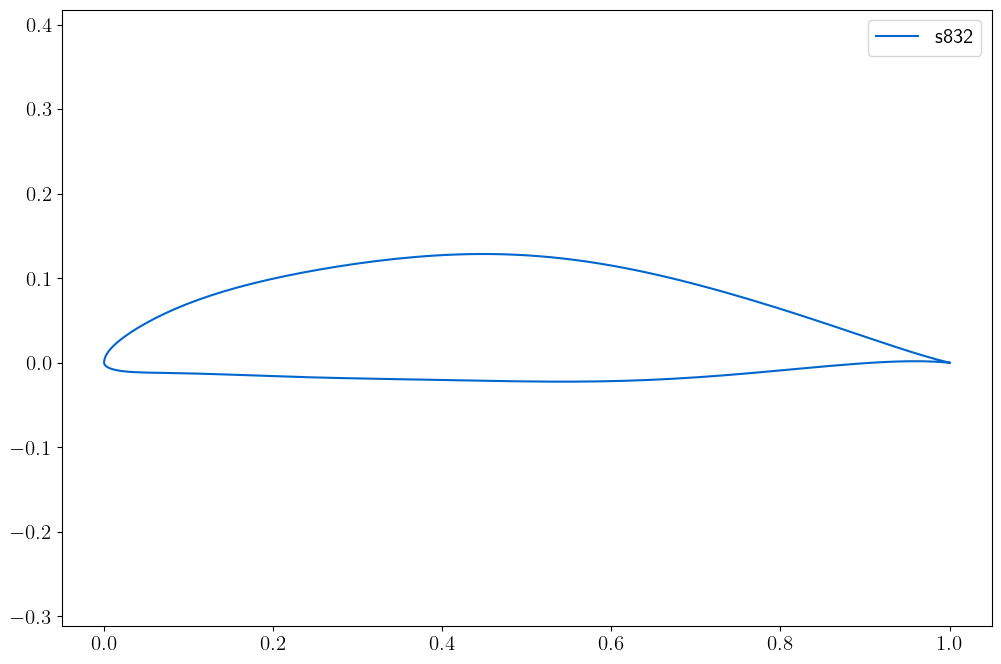

In [6]:
airfoils_to_plot = []
# airfoils_to_plot.append( 'naca0015'  )
# airfoils_to_plot.append( 'naca2418'  )

# airfoils_to_plot.append( 'du_95-w-180'  )
# airfoils_to_plot.append( 'du_96-w-180'  )
# airfoils_to_plot.append( 'du_93-w-210'  )
# airfoils_to_plot.append( 'du_00-w-212'  )
# airfoils_to_plot.append( 'du_91-w2-250' )
# airfoils_to_plot.append( 'du_97-w-300'  )
# airfoils_to_plot.append( 'du_00-w2-350' )
# airfoils_to_plot.append( 'du_00-w2-401' )
 
# airfoils_to_plot.append( 'ffa-w1-128'   )
# airfoils_to_plot.append( 'ffa-w1-152'   )
# airfoils_to_plot.append( 'ffa-w1-182'   )
# airfoils_to_plot.append( 'ffa-w1-211'   )
# airfoils_to_plot.append( 'ffa-w1-242'   )
# airfoils_to_plot.append( 'ffa-w1-271'   )

# airfoils_to_plot.append( 'ffa-w2-152'   )
# airfoils_to_plot.append( 'ffa-w2-210'   )

# airfoils_to_plot.append( 'ffa-w3-211'   )
# airfoils_to_plot.append( 'ffa-w3-241'   )
# airfoils_to_plot.append( 'ffa-w3-270'   )
# airfoils_to_plot.append( 'ffa-w3-301'   )
# airfoils_to_plot.append( 'ffa-w3-332'   )
# airfoils_to_plot.append( 'ffa-w3-360'   )

# airfoils_to_plot.append( 'ffa-w1-128'   )
# airfoils_to_plot.append( 'ffa-w2-152'   )
# airfoils_to_plot.append( 'ffa-w1-182'   )
# airfoils_to_plot.append( 'ffa-w3-211'   )
# airfoils_to_plot.append( 'ffa-w3-241'   )
# airfoils_to_plot.append( 'ffa-w3-270'   )
# airfoils_to_plot.append( 'ffa-w3-301'   )
# airfoils_to_plot.append( 'ffa-w3-332'   )
# airfoils_to_plot.append( 'ffa-w3-360'   )

# airfoils_to_plot.append( 'riso-a-12'    )
# airfoils_to_plot.append( 'riso-a-15'    )
# airfoils_to_plot.append( 'riso-a-18'    )
# airfoils_to_plot.append( 'riso-a-21'    )
# airfoils_to_plot.append( 'riso-a-24'    )
# airfoils_to_plot.append( 'riso-a-27'    )
# airfoils_to_plot.append( 'riso-a-30'    )

# airfoils_to_plot.append( 'riso-b-15'    )
# airfoils_to_plot.append( 'riso-b-17'    )
# airfoils_to_plot.append( 'riso-b-20'    )
# airfoils_to_plot.append( 'riso-b-23'    )
# airfoils_to_plot.append( 'riso-b-29'    )
# airfoils_to_plot.append( 'riso-b-35'    )

# airfoils_to_plot.append( 'riso-p-15'    )
# airfoils_to_plot.append( 'riso-p-18'    )
# airfoils_to_plot.append( 'riso-p-20'    )
# airfoils_to_plot.append( 'riso-p-23'    )

# 40-50m
airfoils_to_plot.append( 's832' ) # 15%
# airfoils_to_plot.append( 's831' ) # 18%
# airfoils_to_plot.append( 's830' ) # 21%
# airfoils_to_plot.append( 's818' ) # 24%

#20-40m
# airfoils_to_plot.append( 's826' ) # 14%
# airfoils_to_plot.append( 's825' ) # 17%
# airfoils_to_plot.append( 's814' ) # 24%
# airfoils_to_plot.append( 's815' ) # 26%


fig = plt.figure(figsize=(12,8))
for afl in airfoils_to_plot:
    afl_geo = generateAirfoil(afl)
    afl_geo.chord = 1.0*units.m
    plt.plot(afl_geo.xcoordinates, afl_geo.ycoordinates, label = afl)

plt.legend()
plt.axis('equal');


/var/folders/z6/4z02kvpd5b7136h_bqz1y2xw0048w3/T/ipykernel_69510/3477749676.py:98: RuntimeWarning: invalid value encountered in scalar divide
  color_frac = (np.log10(Re_value) - np.log10(re_min)) / (np.log10(re_max)-np.log10(re_min))


ValueError: cannot convert float NaN to integer

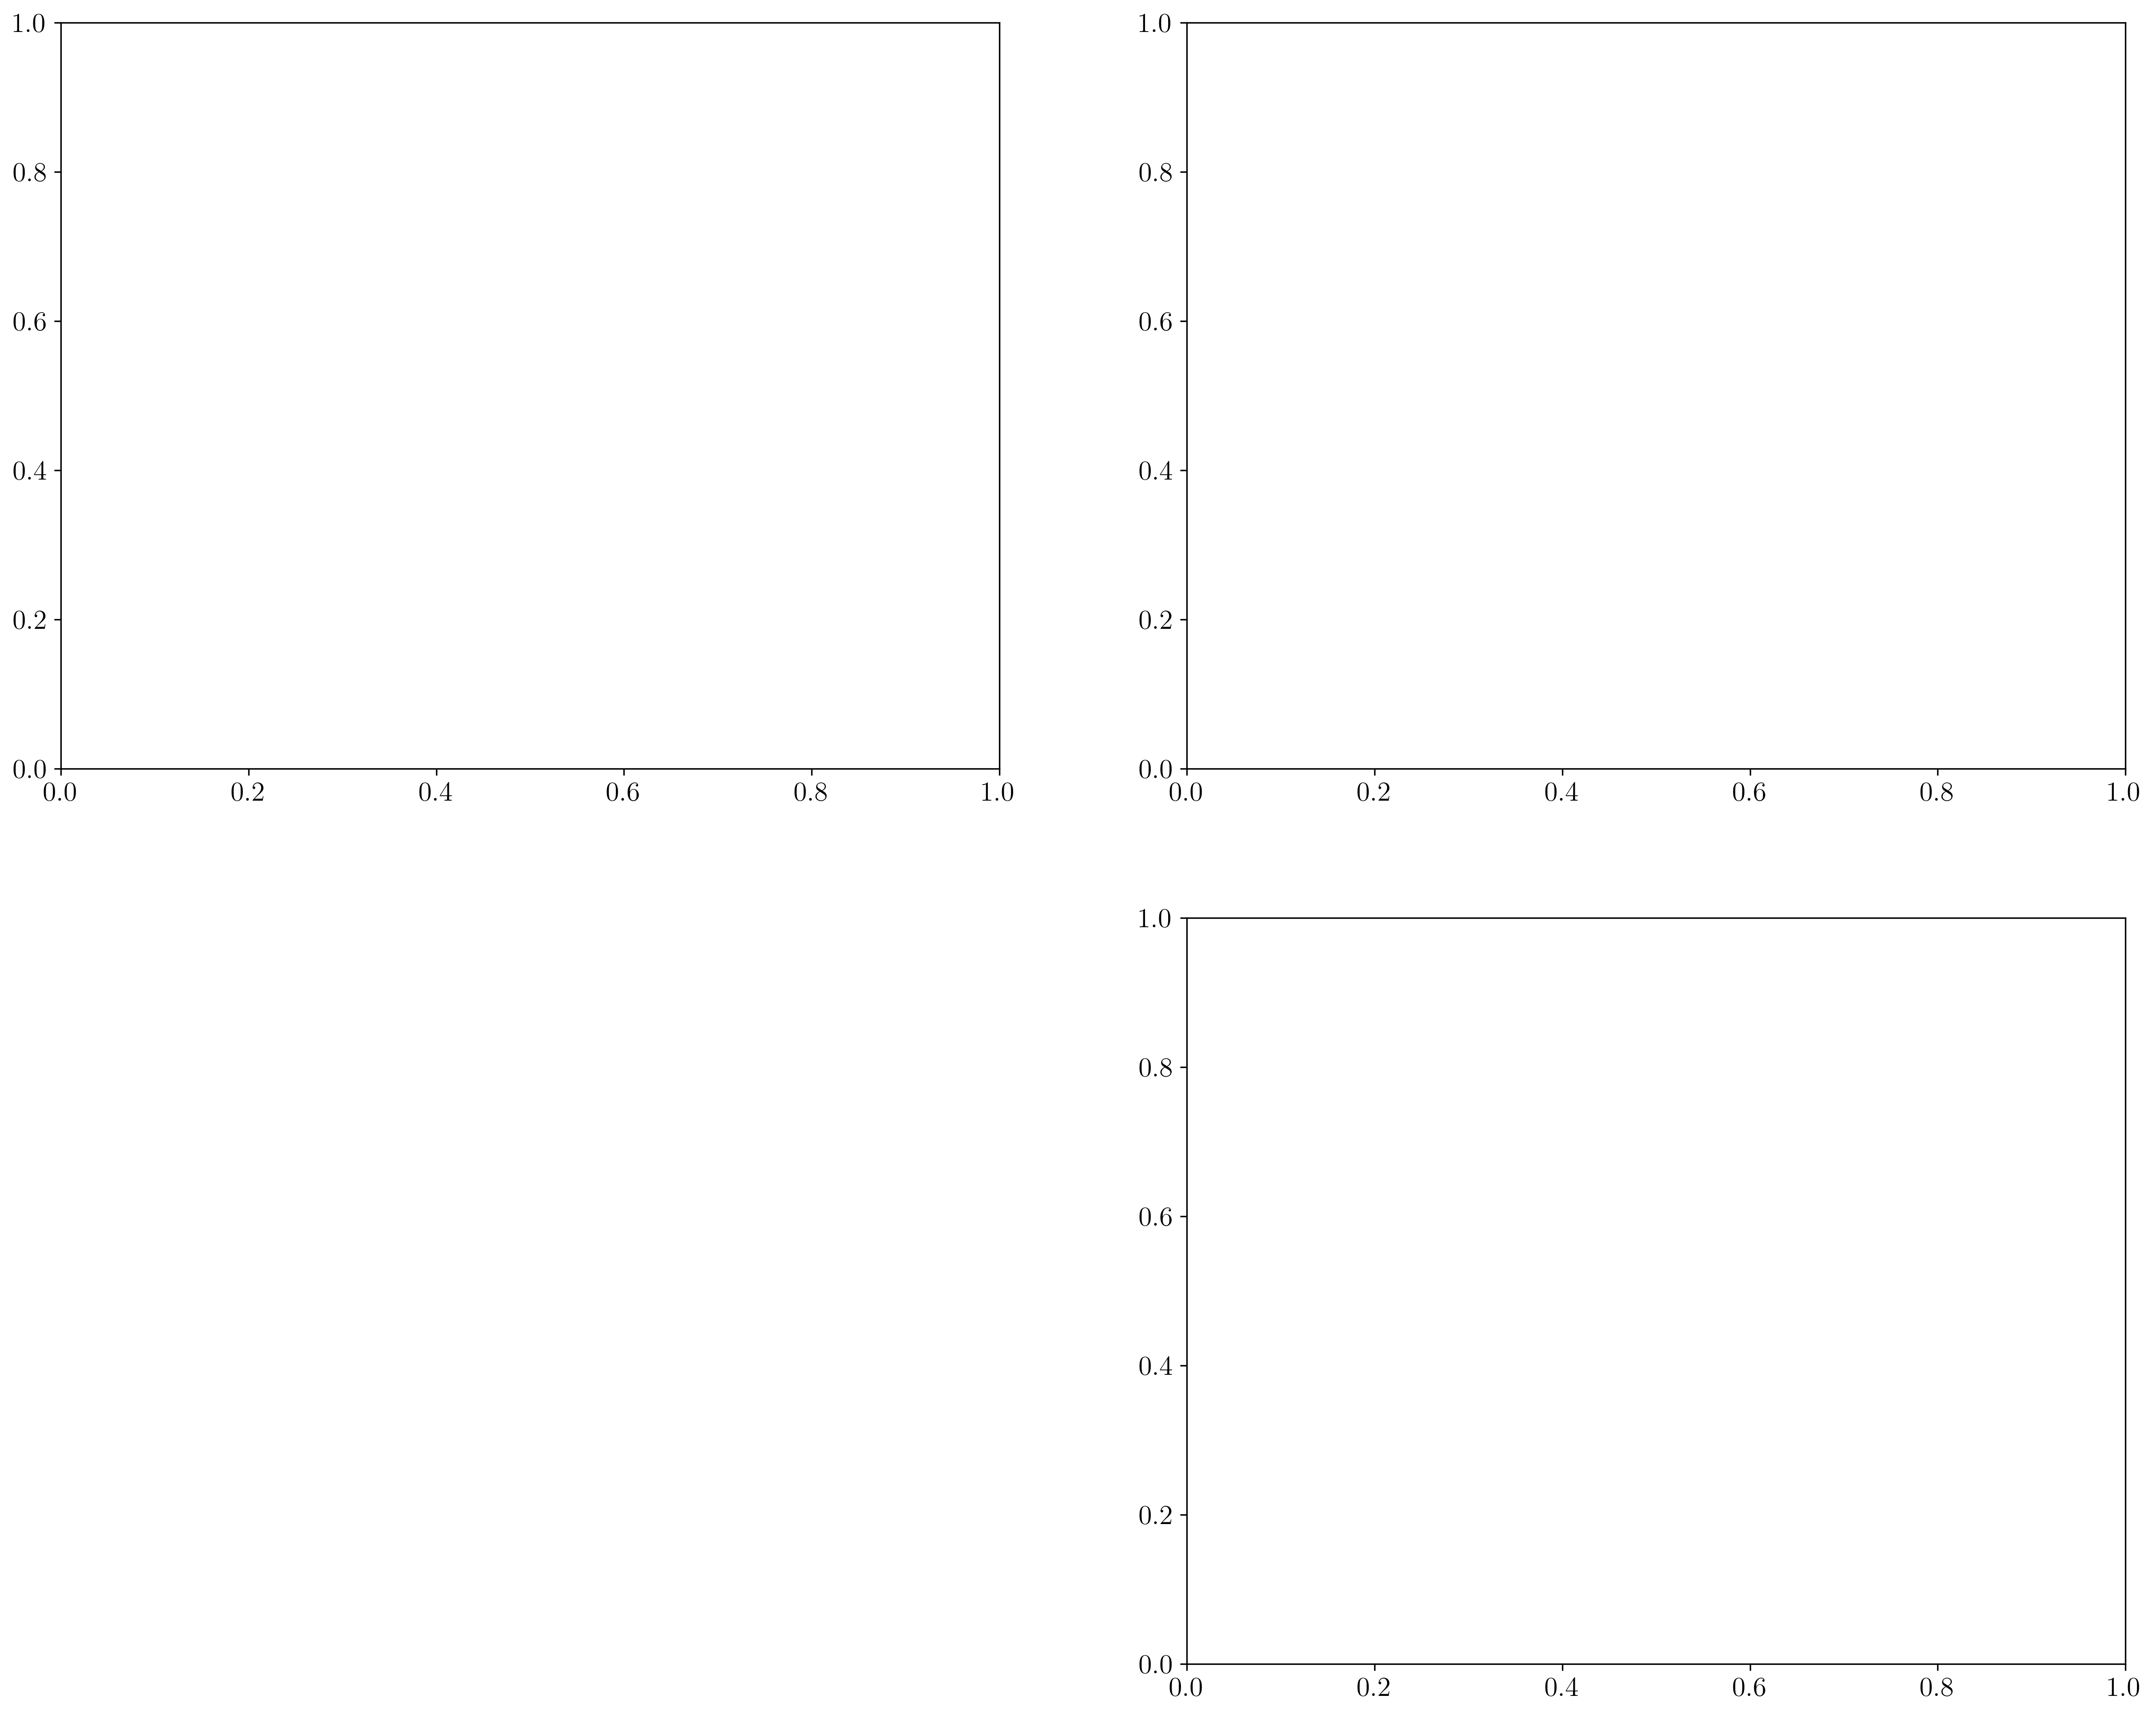

In [4]:
airfoils_to_plot = []
# airfoils_to_plot.append( 'naca0015'  )
# airfoils_to_plot.append( 'naca2418'  )

# airfoils_to_plot.append( 'du_95-w-180'  )
# airfoils_to_plot.append( 'du_96-w-180'  )
# airfoils_to_plot.append( 'du_93-w-210'  )
# airfoils_to_plot.append( 'du_00-w-212'  )
# airfoils_to_plot.append( 'du_91-w2-250' )
# airfoils_to_plot.append( 'du_97-w-300'  )
# airfoils_to_plot.append( 'du_00-w2-350' )
# airfoils_to_plot.append( 'du_00-w2-401' )
 
# airfoils_to_plot.append( 'ffa-w1-128'   )
# airfoils_to_plot.append( 'ffa-w1-152'   )
# airfoils_to_plot.append( 'ffa-w1-182'   )
# airfoils_to_plot.append( 'ffa-w1-211'   )
# airfoils_to_plot.append( 'ffa-w1-242'   )
# airfoils_to_plot.append( 'ffa-w1-271'   )

# airfoils_to_plot.append( 'ffa-w2-152'   )
# airfoils_to_plot.append( 'ffa-w2-210'   )

# airfoils_to_plot.append( 'ffa-w3-211'   )
# airfoils_to_plot.append( 'ffa-w3-241'   )
# airfoils_to_plot.append( 'ffa-w3-270'   )
# airfoils_to_plot.append( 'ffa-w3-301'   )
# airfoils_to_plot.append( 'ffa-w3-332'   )
# airfoils_to_plot.append( 'ffa-w3-360'   )

# airfoils_to_plot.append( 'ffa-w1-128'   )
# airfoils_to_plot.append( 'ffa-w2-152'   )
# airfoils_to_plot.append( 'ffa-w1-182'   )
# airfoils_to_plot.append( 'ffa-w3-211'   )
# airfoils_to_plot.append( 'ffa-w3-241'   )
# airfoils_to_plot.append( 'ffa-w3-270'   )
# airfoils_to_plot.append( 'ffa-w3-301'   )
# airfoils_to_plot.append( 'ffa-w3-332'   )
# airfoils_to_plot.append( 'ffa-w3-360'   )

# airfoils_to_plot.append( 'riso-a-12'    )
# airfoils_to_plot.append( 'riso-a-15'    )
# airfoils_to_plot.append( 'riso-a-18'    )
# airfoils_to_plot.append( 'riso-a-21'    )
# airfoils_to_plot.append( 'riso-a-24'    )
# airfoils_to_plot.append( 'riso-a-27'    )
# airfoils_to_plot.append( 'riso-a-30'    )

# airfoils_to_plot.append( 'riso-b-15'    )
# airfoils_to_plot.append( 'riso-b-17'    )
# airfoils_to_plot.append( 'riso-b-20'    )
# airfoils_to_plot.append( 'riso-b-23'    )
# airfoils_to_plot.append( 'riso-b-29'    )
# airfoils_to_plot.append( 'riso-b-35'    )

# airfoils_to_plot.append( 'riso-p-15'    )
# airfoils_to_plot.append( 'riso-p-18'    )
# airfoils_to_plot.append( 'riso-p-20'    )
# airfoils_to_plot.append( 'riso-p-23'    )

# 40-50m
airfoils_to_plot.append( 's832' ) # 15%
# airfoils_to_plot.append( 's831' ) # 18%
# airfoils_to_plot.append( 's830' ) # 21%
# airfoils_to_plot.append( 's818' ) # 24%

#20-40m
# airfoils_to_plot.append( 's826' ) # 14%
# airfoils_to_plot.append( 's825' ) # 17%
# airfoils_to_plot.append( 's814' ) # 24%
# airfoils_to_plot.append( 's815' ) # 26%

if airfoils_to_plot == []:
    airfoils_to_plot = np.unique(np.array(df_master['name'].to_list()))


Re_list = np.unique(np.array(df_master['re'].to_list()).round(0))
Re_vals = [Re_list[-1]]
Re_vals = Re_list

colorCycle = ['Blues','Oranges','Greens','Purples','Reds','jet','viridis']

re_min = min(df_master['re'].to_list())
re_max = max(df_master['re'].to_list())


fig = plt.figure(figsize=(20,16), dpi=300)
gs = GridSpec(2,2, figure=fig)
ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[0,1])
ax3 = fig.add_subplot(gs[1,1])

for i,aflName in enumerate(airfoils_to_plot):
    df = df_master.loc[(df_master['name']==aflName)]

    # Re_list = np.unique(np.array(df['re'].to_list()).round(0))
    for ii, Re_value in enumerate(Re_vals):
        color_frac = (np.log10(Re_value) - np.log10(re_min)) / (np.log10(re_max)-np.log10(re_min))
        plot_color = get_fractional_color(color_frac, colorCycle[i], lower=0.3, upper=0.8)
        # plot_color = get_fractional_color(color_frac, colorCycle[i], lower=0.6, upper=0.6)

        commonRe = df.loc[(abs(df_master['re'] - Re_value) <= 1)]
        commonRe = commonRe.sort_values('alpha')
        # print(commonRe)
        
        if ii==0:
            ax1.plot(commonRe['cd'],commonRe['cl'], label=aflName.replace('_','-'), color = plot_color)
        else:
            ax1.plot(commonRe['cd'],commonRe['cl'], color = plot_color)

        if i==0:
            ax2.plot(commonRe['alpha'],commonRe['cl'], label='Re=%.2e'%(Re_value), color = plot_color)
        else:
            ax2.plot(commonRe['alpha'],commonRe['cl'], color = plot_color)

        # if ii==0:
        #     ax3.plot(commonRe['alpha'],commonRe['cm'], label='Re=%.2e'%(Re_value), color = plot_color)
        # else:
        ax3.plot(commonRe['alpha'],commonRe['cm'], color = plot_color)

    
ax1.set_xlim([0,0.03])
ax1.set_ylabel('$C_L$')
ax1.set_xlabel('$C_D$')
ax1.grid(1)
ax1.legend()

ax2.set_ylabel('$C_L$')
ax2.set_xlabel(r'$\alpha$')
ax2.grid(1)
ax2.legend()

ax3.set_ylabel('$C_M$')
ax3.set_xlabel(r'$\alpha$')
ax3.grid(1)
# ax3.legend()

plt.tight_layout()